In [1]:
import torch
import torchaudio
import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import numpy as np
import ftfy

In [2]:
root = '/home/stud_vantuan/projects/md_d_vlsp_2023/data'

paths = {
    'train': {
        'phone_csv': root + '/metadata/train_phones.csv',
        'word_csv': root + '/metadata/train.csv',
        'root': root
    },
    'public_test': {
        'phone_csv': root + '/VMD-VLSP23-public-test/meta_data/public_test_phones.csv',
        'word_csv': root + '/VMD-VLSP23-public-test/meta_data/public_test.csv',
        'root': root + '/VMD-VLSP23-public-test'
    },
    'private_test': {
        'phone_csv': root + '/VMD-VLSP23-private-test/metadata/private_test_submission.csv',
        'root': root + '/VMD-VLSP23-private-test'
    }
}

In [3]:
train_audios = glob.glob(paths['train']['root'] + '/audio_data/train/*.wav')
len(train_audios)

3384

In [4]:
public_test_audios = glob.glob(paths['public_test']['root'] + '/audio_data/public_test/*.wav')
len(public_test_audios)

718

In [5]:
private_test_audios = glob.glob(paths['private_test']['root'] + '/audio_data/private_test/*.wav')
len(private_test_audios)

1182

In [6]:
for i in tqdm(private_test_audios):
    fix_path = ftfy.fix_text(i)
    wav, sr = torchaudio.load(i)
    torchaudio.save(fix_path, wav, sr)

  0%|          | 0/1182 [00:00<?, ?it/s]

In [7]:
def get_info(name, paths):
    # training
    lengths = []
    for i in tqdm(paths):
        wav, sr = torchaudio.load(i)
        lengths.append(wav.size(1) / sr)

    return {
        'name': name,
        'min': round(np.min(lengths), 2),
        'max': round(np.max(lengths), 2),
        'mean': np.mean(lengths),
        'median': np.median(lengths),
        'quantile_96': np.quantile(lengths, 0.96),
        'total': round(np.sum(lengths) / 60 / 60, 2)
    }

In [8]:
get_info('train', train_audios)

  0%|          | 0/3384 [00:00<?, ?it/s]

{'name': 'train',
 'min': 0.54,
 'max': 19.81,
 'mean': 4.16186628250591,
 'median': 3.3929375,
 'quantile_96': 10.266742499999994,
 'total': 3.91}

In [9]:
get_info('public_test', public_test_audios)

  0%|          | 0/718 [00:00<?, ?it/s]

{'name': 'public_test',
 'min': 1.2,
 'max': 18.46,
 'mean': 3.2566323119777154,
 'median': 2.5915,
 'quantile_96': 7.12761499999999,
 'total': 0.65}

In [10]:
get_info('private_test', private_test_audios)

  0%|          | 0/1182 [00:00<?, ?it/s]

{'name': 'private_test',
 'min': 1.11,
 'max': 18.45,
 'mean': 2.841986992385787,
 'median': 2.24,
 'quantile_96': 6.575875,
 'total': 0.93}

In [11]:
tonal_symbols = {
    6: 'ạặậẹệọộợịụỵ',
    5: 'ãẵẫẽễõỗỡĩũỹ',
    4: 'ảẳẩẻểỏổởỉủỷ',
    3: 'áắấéếóốớíúý',
    2: 'àằầèềòồờìùỳ',
}

def get_tonal(word):
    for k, symbols in tonal_symbols.items():
        for v in symbols:
            if v in word:
                return k
    return 1

def get_list_tonal(text):
    return [get_tonal(w) for w in text.split()]

In [12]:
def create_data(phone_csv, word_csv, root, have_text=False):
    df = pd.read_csv(phone_csv)
    word_df = pd.read_csv(word_csv)

    sub_df = df[['id', 'path', 'canonical', 'transcript']]
    sub_df['text'] = word_df['transcript']
    
    sub_df['tonal'] = sub_df['text'].map(get_list_tonal)

    if have_text:
        shuffled_df = shuffled_df.drop('text', axis=1)

    sub_df['path'] = sub_df.path.map(lambda x: root + '/' + x)

    sub_data = list(sub_df.T.to_dict().values())
    return sub_data

In [13]:
train_data = create_data(**paths['train'])
public_test_data = create_data(**paths['public_test'])

In [14]:
new_public_test_data = []
for i in public_test_data:
    if 'bia-dat' not in i['path']:
        new_public_test_data.append(i)
len(new_public_test_data), len(public_test_data)

(717, 718)

In [15]:
public_test_data = new_public_test_data

In [16]:
train_data[-1]

{'id': 'bia-dat_1618738038209',
 'path': '/home/stud_vantuan/projects/md_d_vlsp_2023/data/audio_data/train/bia-dat_1618738038209.wav',
 'canonical': 'ɓ iə-5 $ ɗ a-0 tz',
 'transcript': 'ɓ iə-4 $ ɗ a-0 tz',
 'text': 'bía đăt',
 'tonal': [3, 1]}

In [17]:
df = pd.read_csv(paths['private_test']['phone_csv'])
df['path'] = df['path'].map(lambda x: ftfy.fix_text(paths['private_test']['root'] + '/' + x))
private_test_data = list(df[['id', 'path', 'canonical', 'transcript']].T.to_dict().values())
private_test_data[:2]

[{'id': 'vao-nui_1618754903173',
  'path': '/home/stud_vantuan/projects/md_d_vlsp_2023/data/VMD-VLSP23-private-test/audio_data/private_test/vao-nui_1618754903173.wav',
  'canonical': 'v aː-1 uz $ n w i-4',
  'transcript': 'v aː-1 uz $ n w i-3'},
 {'id': 'vao-nui_1618754909868',
  'path': '/home/stud_vantuan/projects/md_d_vlsp_2023/data/VMD-VLSP23-private-test/audio_data/private_test/vao-nui_1618754909868.wav',
  'canonical': 'v aː-1 uz $ n w i-4',
  'transcript': 'v aː-1 uz $ n w i-4'}]

In [18]:
len(train_data), len(public_test_data), len(private_test_data)

(3384, 717, 880)

In [19]:
train_data[0]

{'id': 'THA_Nu_6_S00042_201',
 'path': '/home/stud_vantuan/projects/md_d_vlsp_2023/data/audio_data/train/THA_Nu_6_S00042_201.wav',
 'canonical': 'aː-0 $ m aː-4 $ ɗ aː-2 $ k ɔ-4 $ ɓ ɛ-4 $ l e-0 $ k ɔ-4 $ h aː-1 $ l aː-1 $ k w aː-1 $ k w i-4',
 'transcript': 'aː-0 $ m aː-4 $ ɗ aː-2 $ k ɔ-4 $ ɓ ɛ-4 $ l e-0 $ k ɔ-4 $ h aː-1 $ l aː-1 $ k w aː-1 $ k w i-4',
 'text': 'à má đã có bé lê có hà là quà quý',
 'tonal': [2, 3, 5, 3, 3, 1, 3, 2, 2, 2, 3]}

In [20]:
public_test_data[600]

{'id': 'CPT_Nu_6_S0004_98',
 'path': '/home/stud_vantuan/projects/md_d_vlsp_2023/data/VMD-VLSP23-public-test/audio_data/public_test/CPT_Nu_6_S0004_98.wav',
 'canonical': 'l aː-1 $ v uə-0 $ k uə-3 $ ɓ iə-3 nz',
 'transcript': 'l aː-1 $ v uə-0 $ k uə-3 $ ɓ iə-3 nz',
 'text': 'là vua của biển',
 'tonal': [2, 1, 4, 4]}

In [21]:
len(set([j for i in [' '.join(k['canonical'].split(' $ ')).split(' ') for k in private_test_data] for j in i]))

120

In [22]:
train_cnt = [(i['canonical'].count('$') > 1) for i in train_data]
public_test_cnt = [(i['canonical'].count('$') > 1) for i in public_test_data]
private_test_cnt = [(i['canonical'].count('$') > 1) for i in private_test_data]

In [23]:
round(sum(train_cnt) / len(train_cnt) * 100, 2)

91.52

In [24]:
round(sum(public_test_cnt) / len(public_test_cnt) * 100, 2)

65.69

In [25]:
round(sum(private_test_cnt) / len(private_test_cnt) * 100, 2)

74.09

In [26]:
save_path = '/home/stud_vantuan/projects/md_d_vlsp_2023/data/splitted_data'

with open(os.path.join(save_path, 'train.json'), 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False)

with open(os.path.join(save_path, 'public_test.json'), 'w', encoding='utf-8') as f:
    json.dump(public_test_data, f, ensure_ascii=False)

with open(os.path.join(save_path, 'private_test.json'), 'w', encoding='utf-8') as f:
    json.dump(private_test_data, f, ensure_ascii=False)

In [31]:
def cal_diff(i):
    return len(set(i['transcript']) ^ set(i['canonical']))

In [47]:
train_diff = [cal_diff(i) for i in train_data]
public_test_diff = [cal_diff(i) for i in public_test_data]
private_test_diff = [cal_diff(i) for i in private_test_data]

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
data = pd.DataFrame({
    'diff': train_diff + public_test_diff + private_test_diff,
    'kind': len(train_diff) * ['train'] + len(public_test_diff) * ['public_test'] + len(private_test_diff) * ['private_test']
})
data

,diff,kind
0,0,train
1,0,train
2,0,train
3,0,train
4,0,train
...,...,...
4976,3,private_test
4977,0,private_test
4978,0,private_test
4979,5,private_test


In [163]:
def create(kind):
    a = data[data['kind'] == kind][['diff']].value_counts()
    y = list(a)
    x = list(a.reset_index()['diff'].values)
    return x, y

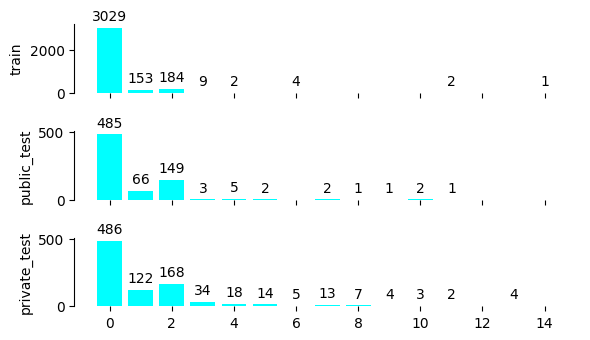

In [176]:
fig, ax = plt.subplots(figsize=(6, 3.5), nrows=3, sharex=True)

def draw(ax, kind):
    x, y = create(kind)
    # sns.barplot(data=pd.DataFrame({'x': x, 'y': y}), x='x', y='y', ax=ax)
    ax.bar(x, y, color='cyan')
    
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
    
        # Number of points between bar and label. Change to your liking.
        space = 3
        # Vertical alignment for positive values
        va = 'bottom'
    
        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'
    
        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)
    
        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',
            va=va,
            color='black')                      # Vertically align label differently for
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)

    ax.set_ylabel(kind)
    ax.set_xlabel('')

draw(ax[0], 'train')
draw(ax[1], 'public_test')
draw(ax[2], 'private_test')

fig.tight_layout()
plt.savefig('miss_distribution.pdf')

plt.show()

/home/stud_vantuan/anaconda3/envs/noise/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/stud_vantuan/anaconda3/envs/noise/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/stud_vantuan/anaconda3/envs/noise/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/stud_vantuan/anaconda3/envs/noise/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

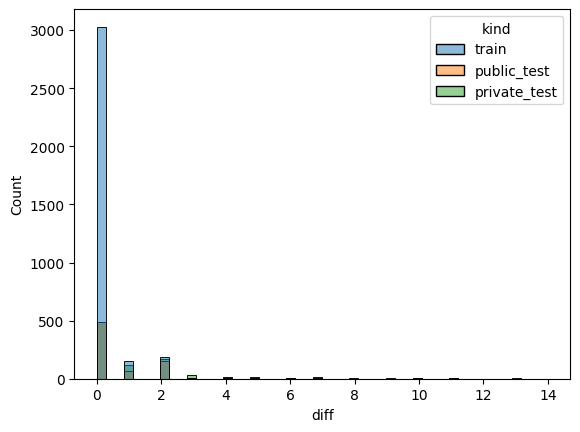

In [55]:
fig, ax = plt.subplots()
sns.histplot(data, x='diff', hue='kind', bins=50)
plt.show()

# Old

In [27]:
# np.random.seed(100)
# shuffled_df = sub_df.sample(frac=1)
# shuffled_df['tonal'] = shuffled_df['text'].map(get_list_tonal)
# shuffled_df = shuffled_df.drop('text', axis=1)
# shuffled_df['path'] = shuffled_df.path.map(lambda x: root_audio + '/' + x)
# shuffled_data = list(shuffled_df.T.to_dict().values())
# train_ratio = round(0.95 * df.shape[0])
# train_data = shuffled_data[:train_ratio]
# test_data = shuffled_data[train_ratio:]